# DATA IMPORTATION AND PROCESSING

In [1]:
#Importing data processing packages
import pandas as pd
import itertools

In [2]:
#Defining data path
dataset_path = r"C:\Users\Achor\Downloads\dataset.xlsx"

In [3]:
#Reading the dataset from Excel files
dataset = pd.read_excel(dataset_path, sheet_name = 'DATASET', keep_default_na=False)

In [4]:
# splitting lists with ### separator and converting relevant columns to strings
for col in dataset.columns:
    if type(dataset[col][0]) == str:
        if dataset[col].str.contains(" ### ").any():
            new_col = dataset[col].str.split(" ### ")
            dataset[col] = new_col

In [5]:
#Inspecting dataset
dataset.head()

,doc_no,annotator,struggle,cluster_expert,cluster_expert_merged,cluster_auto,struggle_original,OT,reflection_candidates,reflection_annotation,...,reframing_annotation,reframing_from_expert,comfort_candidates,comfort_annotation,comfort_from_expert,suggestion_candidates,suggestion_annotation,suggestion_from_expert,reduced_embeddings,full_embeddings
0,1,1,When dieting I often find it hard to track my ...,CALORIE_COUNTING,DIET_PLAN_ISSUES,find_calorie_time,When dieting I often find it hard to track my ...,N,"[So, do you mean that tracking your calorie in...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],[It can happen to anyone to find it difficult ...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],"[Starting from tomorrow, you could try trackin...","[N, Y, Y, N, Y, N, Y, Y, Y, Y]",[N/A],"[-0.38553035, 9.694216, 8.311511]","[-0.04257814213633537, 0.045637574046850204, 0..."
1,2,1,Saying no to alcohol in social settings. I usu...,SOCIAL,SOCIAL,feel_alcohol_friend,Saying no to alcohol in social settings. I usu...,N,[Do you mean that saying no to alcohol in soci...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],[It's understandable to struggle with saying n...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],[Starting from tomorrow you could try setting ...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],"[1.6147285, 12.11944, 6.081849]","[0.021132370457053185, -0.020406601950526237, ..."
2,3,1,Healthy food is expensive and earning a middle...,SITUATIONAL,SITUATIONAL,feel_food_junk,Healthy food is expensive and earning a middle...,N,[Do you mean that healthy food options are too...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],[It can happen to feel tempted to grab fast fo...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],"[Starting from tomorrow, you could make a list...","[N, Y, Y, Y, N, Y, Y, Y, Y, Y]",[N/A],"[-0.74341005, 14.221862, 9.163124]","[-0.0352167934179306, 0.06300564110279083, 0.0..."
3,4,1,Working out is hard for me because I'm used to...,MOTIVATION,MOTIVATION,feel_time_gym_day,Working out is hard for me because Im used to ...,N,"[So, do you mean you have trouble creating a n...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],[It's understandable to find it difficult to a...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],"[It could be helpful to set small, achievable ...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],"[4.136178, 9.765074, 7.860414]","[0.022051161155104637, -0.0497511550784111, 0...."
4,5,1,When I see pizza I always want to buy and I en...,CRAVING_HABIT,CRAVING_HABIT,feel_food_junk,When I see pizza I always want to buy and I en...,N,"[So, are you saying that you have a hard time ...","[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",...,"[Y, Y, Y, Y, Y, Y, Y, Y, Y, Y]",[N/A],[Sometimes it can happen that we crave certain...,"[Y, Y, Y, Y, Y, N, Y, Y, Y, Y]",[N/A],"[Starting from tomorrow, you could make a plan...","[N, Y, Y, N, Y, Y, Y, Y, Y, Y]",[N/A],"[-1.5897965, 13.701472, 7.329277]","[-0.009577570483088493, 0.09480103105306625, 0..."


## DROP 'NOT_APPLICABLE' CLUSTER

In [6]:
# Counting the number of rows where 'cluster_expert_merged' is 'NOT_APPLICABLE'
count_not_applicable = dataset[dataset['cluster_expert_merged'] == 'NOT_APPLICABLE'].shape[0]

# Using query to filter out 'NOT_APPLICABLE'
filtered_dataset = dataset.query("cluster_expert_merged != 'NOT_APPLICABLE'")
filtered_dataset.head()

# Calculating the number of rows dropped
rows_dropped = count_not_applicable

# Calculating the number of rows remaining
rows_remaining = filtered_dataset.shape[0]

# Outputing the counts
print("Number of rows dropped:", rows_dropped)
print("Number of rows remaining:", rows_remaining)

Number of rows dropped: 98
Number of rows remaining: 2322


# INSTALLING AND IMPORTING SBERT PACKAGES

In [9]:
!pip install sentence-transformers

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# TRAINING ON DATA SUBSET

## REFLECTION CANDIDATE

In [7]:
# Reading the reflection candidates into a list with bespoke names
reflective_statements = []
reflective_labels = []
for index, row in filtered_dataset.iterrows():
    for statement, annotation in zip(row['reflection_candidates'], row['reflection_annotation']):
        reflective_statements.append(statement)
        reflective_labels.append(1 if annotation == 'Y' else 0)

In [11]:
#Seperating statements by annotation
safe_statements = [stmt for stmt, label in zip(reflective_statements, reflective_labels) if label == 1]
unsafe_statements = [stmt for stmt, label in zip(reflective_statements, reflective_labels) if label == 0]

In [12]:
# Counting the number of safe statements
num_safe_statements = len(safe_statements)

# Counting the number of unsafe statements
num_unsafe_statements = len(unsafe_statements)

# Printing the counts
print(f"Number of safe statements: {num_safe_statements}")
print(f"Number of unsafe statements: {num_unsafe_statements}")

Number of safe statements: 20177
Number of unsafe statements: 3043


### HANDLING SEMANTIC SIMILARITY AND DATA IMBALANCE

In [13]:
#creating embeddings
safe_embeddings = model.encode(safe_statements)
unsafe_embeddings = model.encode(unsafe_statements)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculating cosine similarity between safe and unsafe embeddings
similarity_matrix = cosine_similarity(safe_embeddings, unsafe_embeddings)

### THIS METHOD OF SORTING THE LOWEST SIMILARITIES MINIMIZES THE MAXIMUM (SORTS STATEMENTS BASED ON MAXIMUM SIMILARITY THEN PICKS THE BOTTOM 2500)

In [24]:
import numpy as np

# Calculating the maximum similarity for each safe statement to any unsafe statement
max_similarity_safe_to_unsafe = np.max(similarity_matrix, axis=1)

# Calculating the maximum similarity for each unsafe statement to any safe statement
max_similarity_unsafe_to_safe = np.max(similarity_matrix, axis=0)

# Getting indices of the safe and unsafe statements with the lowest maximum similarities
sorted_indices_safe = np.argsort(max_similarity_safe_to_unsafe)
sorted_indices_unsafe = np.argsort(max_similarity_unsafe_to_safe)

# Selecting the top 2500 safe and unsafe statements with the lowest maximum similarities
selected_safe_indices = sorted_indices_safe[:2500]
selected_unsafe_indices = sorted_indices_unsafe[:2500]

# Retrieving the corresponding statements using these indices
selected_safe_statements = [safe_statements[i] for i in selected_safe_indices]
selected_unsafe_statements = [unsafe_statements[j] for j in selected_unsafe_indices]

# outputing or use these selected statements
print(f"Selected {len(selected_safe_statements)} safe and {len(selected_unsafe_statements)} unsafe statements with the lowest similarity to the opposite class.")

# Printing one sample from each class
print("Sample Safe Statement:")
print(selected_safe_statements[0] if selected_safe_statements else "No safe statements selected.")

print("\nSample Unsafe Statement:")
print(selected_unsafe_statements[1] if selected_unsafe_statements else "No unsafe statements selected.")

Selected 2500 safe and 2500 unsafe statements with the lowest similarity to the opposite class.
Sample Safe Statement:
Do you mean that you have not been able to find reliable information on the internet?

Sample Unsafe Statement:
So, do you mean that your love for Nutella is something that has been present since childhood?


In [25]:
# Generating embeddings for the selected statements
selected_safe_embeddings = model.encode(selected_safe_statements)
selected_unsafe_embeddings = model.encode(selected_unsafe_statements)

# Combining the embeddings and create labels
embeddings = np.vstack((selected_safe_embeddings, selected_unsafe_embeddings))
labels = [1] * len(selected_safe_embeddings) + [0] * len(selected_unsafe_embeddings)

### SPLITING TRAIN/TEST DATA 80/20

In [26]:
from sklearn.model_selection import train_test_split

# Spliting the embedded data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, 
    labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels  # Ensuring the same distribution of classes in both sets
)

### NAIVE BAYES

In [27]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

GaussianNB()

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       500
           1       0.71      0.74      0.72       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



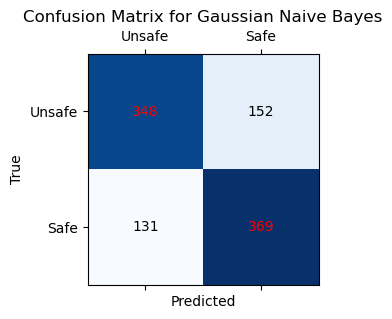

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predicting using the trained Naive Bayes classifier
nb_predictions = nb_classifier.predict(X_test)

# Classification report for Naive Bayes
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classifier_name, labels):
    fig, ax = plt.subplots(figsize=(3, 3))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {classifier_name}')
    
    # SetTING tick positions
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # AnnotatING each cell with the numeric value
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='red' if cm[i,j] > cm.max()/2 else 'black')

    plt.show()

# Computing the confusion matrix
nb_cm = confusion_matrix(y_test, nb_predictions)

# Plotting the confusion matrix using the custom function
plot_confusion_matrix(nb_cm, "Gaussian Naive Bayes", ["Unsafe", "Safe"])

### SUPPORT VECTOR MACHINE

In [30]:
from sklearn.svm import SVC

# Using the same train-test split to maintain consistency
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)

# InitializinG the SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', random_state=42)

# Training the classifier
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       500
           1       0.75      0.82      0.78       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



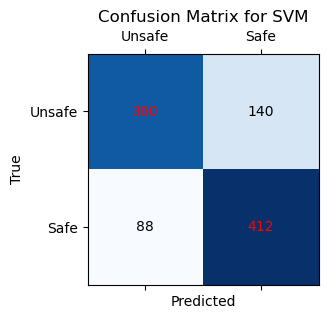

In [31]:
# Predicting using the trained SVM classifier
svm_predictions = svm_classifier.predict(X_test)

# Printing the classification report
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

# Using the same custom function for plotting the confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, svm_predictions), "SVM", ["Unsafe", "Safe"])

## SUGGESTION CANDIDATES

In [35]:
# Initializing lists to store the suggestion candidates and their labels
suggestion_statements = []
suggestion_labels = []

# Iterate through each row in the dataset
for index, row in filtered_dataset.iterrows():
    for statement, annotation in zip(row['suggestion_candidates'], row['suggestion_annotation']):
        suggestion_statements.append(statement)
        suggestion_labels.append(1 if annotation == 'Y' else 0)

In [36]:
# Separating suggestion statements by their annotations
safe_suggestion_statements = [stmt for stmt, label in zip(suggestion_statements, suggestion_labels) if label == 1]
unsafe_suggestion_statements = [stmt for stmt, label in zip(suggestion_statements, suggestion_labels) if label == 0]

In [37]:
# Counting the number of safe suggestion statements
num_safe_suggestion_statements = len(safe_suggestion_statements)

# Counting the number of unsafe suggestion statements
num_unsafe_suggestion_statements = len(unsafe_suggestion_statements)

# Printing the counts
print(f"Number of safe suggestion statements: {num_safe_suggestion_statements}")
print(f"Number of unsafe suggestion statements: {num_unsafe_suggestion_statements}")

Number of safe suggestion statements: 19946
Number of unsafe suggestion statements: 3274


### HANDLING SEMANTIC SIMILARITY AND DATA IMBALANCE

In [38]:
# Generating embeddings for safe and unsafe suggestion statements
safe_suggestion_embeddings = model.encode(safe_suggestion_statements)
unsafe_suggestion_embeddings = model.encode(unsafe_suggestion_statements)

In [39]:
# Calculating cosine similarity between safe and unsafe suggestion embeddings
suggestion_similarity_matrix = cosine_similarity(safe_suggestion_embeddings, unsafe_suggestion_embeddings)

In [40]:
# Calculating the maximum similarity for each safe statement to any unsafe statement
max_similarity_safe_to_unsafe = np.max(suggestion_similarity_matrix, axis=1)

# Calculating the maximum similarity for each unsafe statement to any safe statement
max_similarity_unsafe_to_safe = np.max(suggestion_similarity_matrix, axis=0)

# Getting indices of the safe and unsafe statements with the lowest maximum similarities
sorted_indices_safe = np.argsort(max_similarity_safe_to_unsafe)
sorted_indices_unsafe = np.argsort(max_similarity_unsafe_to_safe)

# Selecting the top 2500 safe and unsafe statements with the lowest maximum similarities
selected_safe_indices = sorted_indices_safe[:2500]
selected_unsafe_indices = sorted_indices_unsafe[:2500]

# Retrieving the corresponding statements using these indices
selected_safe_suggestions = [safe_suggestion_statements[i] for i in selected_safe_indices]
selected_unsafe_suggestions = [unsafe_suggestion_statements[j] for j in selected_unsafe_indices]

# Outputting the selected statements
print(f"Selected {len(selected_safe_suggestions)} safe and {len(selected_unsafe_suggestions)} unsafe statements with the lowest similarity to the opposite class.")

# Printing one sample from each class
print("Sample Safe Statement:")
print(selected_safe_suggestions[0] if selected_safe_suggestions else "No safe statements selected.")

print("\nSample Unsafe Statement:")
print(selected_unsafe_suggestions[0] if selected_unsafe_suggestions else "No unsafe statements selected.")

Selected 2500 safe and 2500 unsafe statements with the lowest similarity to the opposite class.
Sample Safe Statement:
It could be helpful to schedule a visit with your dentist to discuss any concerns you have about cavities and to get a professional cleaning.

Sample Unsafe Statement:
It could be helpful to find a different route to work that doesn't take you by the petrol station.


In [41]:
# Generating embeddings for the selected statements
selected_safe_suggestion_embeddings = model.encode(selected_safe_suggestions)
selected_unsafe_suggestion_embeddings = model.encode(selected_unsafe_suggestions)

# Stack the embeddings vertically (safe on top of unsafe)
embeddings = np.vstack((selected_safe_suggestion_embeddings, selected_unsafe_suggestion_embeddings))

# Create labels (1 for safe, 0 for unsafe)
labels = [1] * len(selected_safe_suggestion_embeddings) + [0] * len(selected_unsafe_suggestion_embeddings)

### TRAIN/TEST SPLIT 80/20

In [42]:
# Split the data into training and testing sets, with stratification to ensure balanced class distribution
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)

### NAIVE BAYES

In [43]:
# Initializing the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Training the classifier on the training data
nb_classifier.fit(X_train, y_train)

GaussianNB()

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       500
           1       0.76      0.80      0.78       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



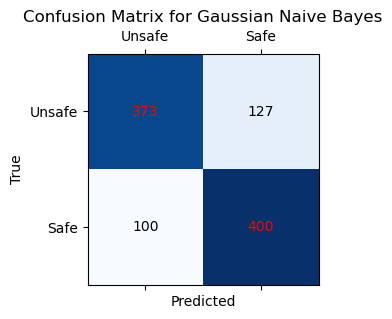

In [44]:
# Predicting using the trained Naive Bayes classifier
nb_predictions = nb_classifier.predict(X_test)

# Generating and print the classification report
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

# Computing the confusion matrix
nb_cm = confusion_matrix(y_test, nb_predictions)

# Plotting the confusion matrix using the already defined function
plot_confusion_matrix(nb_cm, "Gaussian Naive Bayes", ["Unsafe", "Safe"])

### SUPPORT VECTOR MACHINE

In [45]:
# Initializing the SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', random_state=42)

# Training the classifier on the training data
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       500
           1       0.79      0.83      0.81       500

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



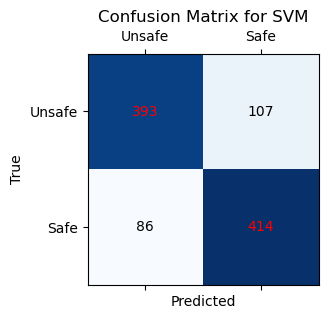

In [46]:
# Predict using the trained SVM classifier
svm_predictions = svm_classifier.predict(X_test)

# Generate and print the classification report
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

# Compute the confusion matrix
svm_cm = confusion_matrix(y_test, svm_predictions)

# Plot the confusion matrix using the already defined function
plot_confusion_matrix(svm_cm, "SVM", ["Unsafe", "Safe"])

In [47]:
# Extract the coefficients of the SVM model
svm_coefficients = svm_classifier.coef_[0]

# Sort the indices of the coefficients based on their absolute values to find the most influential features
top_features_indices = np.argsort(np.abs(svm_coefficients))[-10:]  # For example, top 10 features
top_features_values = svm_coefficients[top_features_indices]

# Print top features and their coefficients
print("Top 10 Features' Coefficients:")
for index, value in zip(top_features_indices, top_features_values):
    print(f"Feature at index {index}: Coefficient {value}")

Top 10 Features' Coefficients:
Feature at index 314: Coefficient 2.036436759936036
Feature at index 305: Coefficient 2.0484054231381723
Feature at index 91: Coefficient 2.05322820373276
Feature at index 251: Coefficient -2.1320122348000794
Feature at index 205: Coefficient 2.199021225369288
Feature at index 288: Coefficient -2.279518981687975
Feature at index 115: Coefficient -2.2829815107640243
Feature at index 300: Coefficient 2.310294017753274
Feature at index 44: Coefficient 2.452788065349009
Feature at index 149: Coefficient 2.6210333518972817


## TRAINING TRADITIONAL MODELS WITH TF-IDF AND REFLECTION STATEMENTS

#### VECTORIZING SELECTED REFLECTION CANDIDATES

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with stop word removal
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Combine selected safe and unsafe reflection statements into a single list
combined_reflection_statements = selected_safe_statements + selected_unsafe_statements

# Generate TF-IDF vectors for the combined reflection statements
reflection_tfidf_vectors = tfidf_vectorizer.fit_transform(combined_reflection_statements)

# Create labels (1 for safe, 0 for unsafe)
reflection_labels = [1] * len(selected_safe_statements) + [0] * len(selected_unsafe_statements)

#### TRAIN-TEST SPLIT (80/20)

In [60]:
# Spliting the TF-IDF data into training and testing sets with stratification
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    reflection_tfidf_vectors, 
    reflection_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=reflection_labels  # Ensuring similar distribution of labels in train and test sets
)

#### NAIVE BAYES

In [61]:
from sklearn.naive_bayes import MultinomialNB

# Initializing the Multinomial Naive Bayes classifier
nb_classifier_refl = MultinomialNB()

# Training the classifier on the TF-IDF training data
nb_classifier_refl.fit(X_train_tfidf, y_train_tfidf)

MultinomialNB()

Naive Bayes Classification Report (Reflection):
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       500
           1       0.81      0.67      0.73       500

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



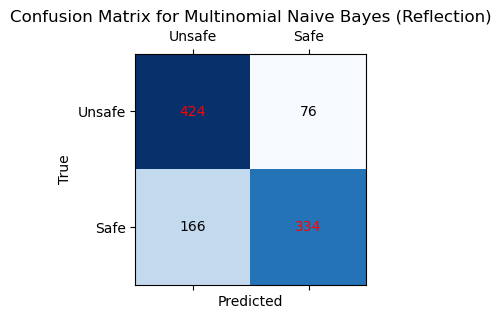

In [62]:
# Predicting using the trained Naive Bayes classifier
nb_predictions_refl = nb_classifier_refl.predict(X_test_tfidf)

# Generating and print the classification report
print("Naive Bayes Classification Report (Reflection):")
print(classification_report(y_test_tfidf, nb_predictions_refl))

# Computing the confusion matrix with unique names
nb_cm_refl = confusion_matrix(y_test_tfidf, nb_predictions_refl)

# Plotting the confusion matrix using the previously defined function
plot_confusion_matrix(nb_cm_refl, "Multinomial Naive Bayes (Reflection)", ["Unsafe", "Safe"])

In [63]:
# Get the log probabilities of features given a class
log_probabilities = nb_classifier_refl.feature_log_prob_

# For instance, extract log probabilities for the 'safe' class (assuming 'safe' is class 1)
safe_log_probs = log_probabilities[1]  # index 1 for 'safe', index 0 for 'unsafe'

# Get the feature names from the TfidfVectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Combine the feature names with their corresponding log probabilities
features_with_probs = list(zip(feature_names, safe_log_probs))

# Sort features by their log probability for the 'safe' class
most_influential_features = sorted(features_with_probs, key=lambda x: x[1], reverse=True)

# Print the top 10 most influential features for the 'safe' class
print("Top 10 influential features for 'Safe' class:")
for feature, log_prob in most_influential_features[:10]:
    print(f"Feature: {feature}, Log Probability: {log_prob}")

Top 10 influential features for 'Safe' class:
Feature: mean, Log Probability: -4.2591536912285
Feature: saying, Log Probability: -4.309348396223697
Feature: feel, Log Probability: -5.119313524863005
Feature: food, Log Probability: -5.301651756954267
Feature: diet, Log Probability: -5.374355906557213
Feature: eating, Log Probability: -5.4038518071154575
Feature: like, Log Probability: -5.4116961603688365
Feature: exercise, Log Probability: -5.428557962272513
Feature: weight, Log Probability: -5.442670973084703
Feature: time, Log Probability: -5.468863760209568


#### SUPPORT VECTOR MACHINE

In [64]:
# Initializing the SVM classifier with a linear kernel
svm_classifier_refl = SVC(kernel='linear', random_state=42)

# Training the classifier on the TF-IDF training data
svm_classifier_refl.fit(X_train_tfidf, y_train_tfidf)

SVC(kernel='linear', random_state=42)

SVM Classification Report (Reflection):
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       500
           1       0.74      0.80      0.77       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



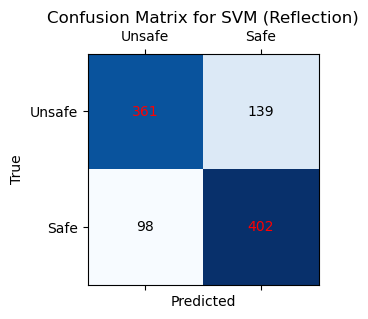

In [65]:
# Predicting using the trained SVM classifier
svm_predictions_refl = svm_classifier_refl.predict(X_test_tfidf)

# Generating and print the classification report
print("SVM Classification Report (Reflection):")
print(classification_report(y_test_tfidf, svm_predictions_refl))

# Computing the confusion matrix
svm_cm_refl = confusion_matrix(y_test_tfidf, svm_predictions_refl)

# confusion matrix
plot_confusion_matrix(svm_cm_refl, "SVM (Reflection)", ["Unsafe", "Safe"])

#### FEATURE EXTRACTION FOR SVM

In [70]:
# Extracting the coefficients from the SVM model and converting to a dense array
coefficients = svm_classifier_refl.coef_.toarray()[0] if hasattr(svm_classifier_refl.coef_, 'toarray') else svm_classifier_refl.coef_[0]

# Getting feature names from the TF-IDF Vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Combining feature names with their corresponding coefficients
features_with_coefficients = list(zip(feature_names, coefficients))

# Sorting features by the magnitude of coefficients for the 'Safe' category (positive coefficients)
top_features_safe = sorted(features_with_coefficients, key=lambda x: x[1], reverse=True)[:10]  # Now retrieving top 10

# Sorting features by the magnitude of coefficients for the 'Unsafe' category (negative coefficients)
top_features_unsafe = sorted(features_with_coefficients, key=lambda x: x[1])[:10]  # Now retrieving top 10

# Printing top 10 features for 'Safe' category
print("Top 10 features for 'Safe' category:")
for feature, coef in top_features_safe:
    print(f"{feature}: {coef:.4f}")

# Printing top 10 features for 'Unsafe' category
print("\nTop 10 features for 'Unsafe' category:")
for feature, coef in top_features_unsafe:
    print(f"{feature}: {coef:.4f}")

Top 10 features for 'Safe' category:
girlfriend: 2.7136
alcohol: 2.5423
drink: 2.2922
toddler: 2.2858
location: 2.1343
portugal: 2.0958
soreness: 2.0737
son: 2.0223
training: 2.0084
country: 2.0061

Top 10 features for 'Unsafe' category:
healthy: -3.5067
sweets: -3.0348
junk: -3.0005
cravings: -2.7903
food: -2.4864
saying: -2.3500
snack: -2.2617
guilty: -2.2378
mean: -2.1748
struggle: -2.1245
